In [ ]:
# Project 2: Planets around TRAPPIST-1 

## Goal and Objectives

Simulate the movements of planets near the star TRAPPIST-1

1. Simulate movement of the 7 closest planets for 10 earth years
2. From which planets can an observer see the most other planets in the night sky?


## Data 

Use pandas during development. Replace with something simpler for project.

In [1]:
import pandas as pd

In [2]:
system = pd.read_hdf("../data/trappist_bodies.hdf5", "LOCAL_UNITS")
system.sort_values('name', inplace=True)

In [3]:
system

,name,mass,period,radius,semi-major,eccentricity
4,b,0.000032,1.510871,1.086,11.11,0.081
2,c,0.000052,2.421823,1.056,15.21,0.083
0,d,0.000015,4.049610,0.772,21.44,0.070
5,e,0.000023,6.099615,0.918,28.17,0.085
1,f,0.000025,9.206690,1.045,37.10,0.063
3,g,0.000050,12.352940,1.127,45.10,0.061
6,h,NaN,20.000000,0.755,63.00,NaN
7,star,1.000000,NaN,0.117,NaN,NaN


In [4]:
planets = system[system['name'] != "star"]
planets = planets.dropna()
star = system[system['name'] == "star"]
M_star = star['mass'].iloc[0]  

assert M_star == 1.0

In [5]:
system_AU = pd.read_hdf("../data/trappist_bodies.hdf5", "SOLAR_UNITS")
M_star_in_solar_mass = system_AU[system_AU['name'] == "star"]['mass'].item()
print(M_star_in_solar_mass)

0.0802


In [6]:
planets

,name,mass,period,radius,semi-major,eccentricity
4,b,0.000032,1.510871,1.086,11.11,0.081
2,c,0.000052,2.421823,1.056,15.21,0.083
0,d,0.000015,4.049610,0.772,21.44,0.070
5,e,0.000023,6.099615,0.918,28.17,0.085
1,f,0.000025,9.206690,1.045,37.10,0.063
3,g,0.000050,12.352940,1.127,45.10,0.061


## Kepler orbits
See Wang Ch 4.2.3

Orbits with sun at one focus (origin). $r_\text{max}$ is the distance of the sun to the aphelion (farthest) point of orbit; $r_\text{min}$ to perihelion. $a$ is the semi-major axis.

$$
r_\text{max} = a(1+e)\\
r_\text{min} = a(1-e)
$$

The velocity at the aphelion is

$$
v_\text{ap} = \sqrt{\frac{k}{ma} \frac{1-e}{1+e}} = \sqrt{\frac{GM}{a} \frac{1-e}{1+e}}
$$

with

$$
k = GmM
$$


In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

# in AU (solar system) units
#G = 4*np.pi**2

# length = 1e-3 AU, time = d, M = M_star
G = 4*np.pi**2 * (1e3)**3 / (365.25)**2 * M_star_in_solar_mass

In [8]:
def rmax(a, e):
    return a*(1+e)

def v_aphelion(a, e, M):
    return np.sqrt(G*M*(1-e)/(a*(1+e)))

In [9]:
planets_x = rmax(planets['semi-major'], planets['eccentricity'])
planets_vy = v_aphelion(planets['semi-major'], planets['eccentricity'], M=M_star)

In [10]:
def F_gravity(r, m, M=1.0):
    rr = np.sum(r*r)
    rhat = r/np.sqrt(rr)
    return -G*m*M/rr * rhat

def U_gravity(r, m, M=1.0):
    return -G*m*M/np.sqrt(np.sum(r*r))

In [11]:
def planet_orbit(r0, v0, mass, M_star=M_star, dt=0.001, t_max=1):
    """2D planetary motion with velocity verlet"""
    dim = len(r0)
    assert len(v0) == dim

    nsteps = int(t_max/dt)

    r = np.zeros((nsteps, dim))
    v = np.zeros_like(r)

    r[0, :] = r0
    v[0, :] = v0

    # start force evaluation for first step
    Ft = F_gravity(r[0], m=mass, M=M_star)
    for i in range(nsteps-1):
        vhalf = v[i] + 0.5*dt * Ft/mass
        r[i+1, :] = r[i] + dt * vhalf
        Ftdt = F_gravity(r[i+1], m=mass, M=M_star)
        v[i+1] = vhalf + 0.5*dt * Ftdt/mass
        # new force becomes old force
        Ft = Ftdt
    
    return r, v

Orbit of TRAPPIST-b (without any additional interactions): establish basic values for run parameters.

In [12]:
idx = planets[planets['name'] == 'b'].index
r0 = np.array([planets_x[idx].item(), 0])
v0 = np.array([0, planets_vy[idx].item()])
mass = planets['mass'][idx].item()

In [13]:
r, v = planet_orbit(r0, v0, mass=mass, M_star=M_star, t_max=1.5, dt=0.01)

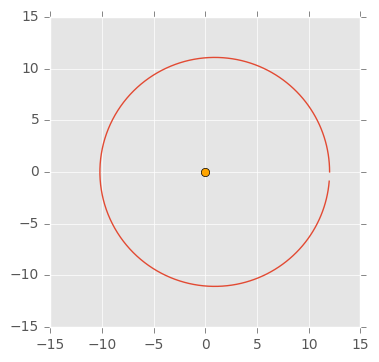

In [14]:
rx, ry = r.T
ax = plt.subplot(1,1,1)
ax.set_aspect(1)
ax.plot(rx, ry)
ax.plot([0], [0], 'o', color="orange")

Looks ok.

In [15]:
planets

,name,mass,period,radius,semi-major,eccentricity
4,b,0.000032,1.510871,1.086,11.11,0.081
2,c,0.000052,2.421823,1.056,15.21,0.083
0,d,0.000015,4.049610,0.772,21.44,0.070
5,e,0.000023,6.099615,0.918,28.17,0.085
1,f,0.000025,9.206690,1.045,37.10,0.063
3,g,0.000050,12.352940,1.127,45.10,0.061


## Many body system 

In [16]:
def orbits(r0, v0, masses, M_star=M_star, dt=0.001, t_max=1):
    """2D planetary motion with velocity verlet for multiple planets"""
    N_planets = len(masses)
    assert r0.shape[0] == N_planets
    dim = r0.shape[1]
    assert np.all(v0.shape == r0.shape)

    nsteps = int(t_max/dt)

    r = np.zeros((nsteps, N_planets, dim))
    v = np.zeros_like(r)

    r[0, :, :] = r0
    v[0, :, :] = v0

    # start force evaluation for first step
    Ft = forces(r[0], masses, M_star)
    for i in range(nsteps-1):
        vhalf = v[i] + 0.5*dt * Ft/masses[:, np.newaxis]
        r[i+1, :] = r[i] + dt * vhalf
        Ftdt = forces(r[i+1], masses, M_star)
        v[i+1] = vhalf + 0.5*dt * Ftdt/masses[:, np.newaxis]
        # new force becomes old force
        Ft = Ftdt
    return r, v

def forces(r, masses, M):
    F = np.zeros_like(r)
    for i, m in enumerate(masses):
        # planet - star
        F[i, :] = F_gravity(r[i], m=m, M=M)
        for j in range(i+1, len(masses)):
            # force of planet j on i
            rij = r[j] - r[i]
            Fij = F_gravity(rij, m=m, M=masses[j])
            F[i] += Fij
            # Newton's 3rd law:
            Fji = -Fij
            F[j] += Fji
    return F
            

In [17]:
r0 = np.array([planets_x, np.zeros_like(planets_x)]).T
v0 = np.array([np.zeros_like(planets_vy), planets_vy]).T
masses = planets['mass'].values

In [18]:
forces(r0, masses, M_star)

array([[-0.00523821, -0.        ],
       [-0.00451957, -0.        ],
       [-0.00069241, -0.        ],
       [-0.00058996, -0.        ],
       [-0.0003889 , -0.        ],
       [-0.00051998, -0.        ]])

In [44]:
r, v = orbits(r0, v0, masses, t_max=5, dt=0.01)

In [45]:
r.shape

(500, 6, 2)

In [46]:
def plot_orbits(r):
    ax = plt.subplot(111)
    ax.set_aspect(1)
    for planet in range(r.shape[1]):
        rx, ry = r[:, planet, :].T
        ax.plot(rx, ry)
        ax.plot(rx[-1], ry[-1], 'o', ms=4, color="gray", alpha=0.5)
    ax.plot([0], [0], 'o', ms=15, color="orange")
    return ax

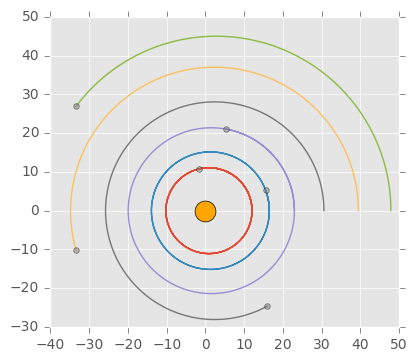

In [47]:
plot_orbits(r)

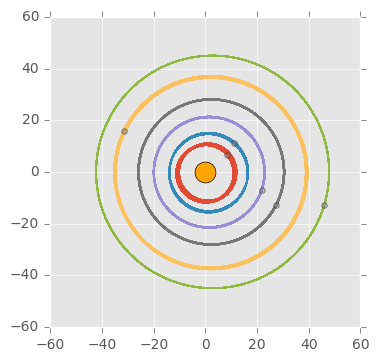

In [52]:
r, v = orbits(r0, v0, masses, t_max=1000, dt=0.01)
plot_orbits(r)